<a href="https://colab.research.google.com/github/gabrielmaranhao/MOSFET_model/blob/main/Examples/GF180MCU/GF180MCU_ACM2V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Configure NGSPICE environment with OSDI + GF180mcu PDK  {display-mode: "form"}
#@markdown Takes around 10 minutes. It is necessary to compile ngspice directly,
#@markdown as only ngspice 39+ comes with OSDI option enabled.

from cmath import exp
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.patches as patches
import pandas as pd
import numpy as np

import csv

!sudo apt-get update
!sudo apt-get install -y libtool
!sudo apt-get install -y libxaw7-dev
!sudo apt-get install -y bison

!git clone https://git.code.sf.net/p/ngspice/ngspice ngspice

%cd /content/ngspice

!./autogen.sh
!./configure --with-x --disable-debug --enable-cider --with-readline=yes --enable-openmp --enable-osdi
!make
!sudo make install

import os
os.environ['PATH'] = '/usr/local/bin:' + os.environ['PATH']
!ngspice --version

%cd ..

#----------------Install OPENVAF - VerilogA compiler--------------------
#
#
!wget https://openva.fra1.cdn.digitaloceanspaces.com/openvaf_23_2_0_linux_amd64.tar.xz
!tar -xf openvaf_23_2_0_linux_amd64.tar.xz

os.environ['PATH'] += ":/content"

!chmod +x /content/openvaf
!rm -f openvaf_23_2_0_linux_amd64.tar.xz
#
#
#------------------------------------------------------------------------


############ GF180MCU ##############

# Install GF180nm dependencies {display-mode: "form"}

#ngspice_version = '39' #@param {type:"string"}
gf180mcu_fd_pr_version = 'latest'

if gf180mcu_fd_pr_version == 'latest':
  gf180mcu_fd_pr_version = 'main'

import os
import pathlib
import urllib.request

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned


ngspice_models_dir = pathlib.Path('globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice')
ngspice_models_dir.mkdir(exist_ok=True, parents=True)
models = ['design.ngspice', 'sm141064.ngspice', 'sm141064_mim.ngspice', 'smbb000149.ngspice']
for m in models:
  url = f'https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/{gf180mcu_fd_pr_version}/models/ngspice/{m}'
  print('downloading:', url)
  with urllib.request.urlopen(url) as src:
    with (ngspice_models_dir / m).open('wb') as dst:
      dst.write(src.read())

PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}

###################################


In [16]:
#@title Run OPENVAF - generate OSDI files from Verilog files
#OpenVAF version: openvaf_23_5_0_linux_amd64.tar.xz
#From: https://openvaf.semimod.de/

#get .va files
!git clone https://github.com/ACMmodel/MOSFET_model.git
!cp MOSFET_model/Verilog-A/NMOS_ACM_2V0.va /content/
!cp MOSFET_model/Verilog-A/PMOS_ACM_2V0.va /content/

#Insert ".va" file path
!openvaf NMOS_ACM_2V0.va
!openvaf PMOS_ACM_2V0.va

fatal: destination path 'MOSFET_model' already exists and is not an empty directory.
Finished building NMOS_ACM_2V0.va in 0.30s
Finished building PMOS_ACM_2V0.va in 0.30s


In [ ]:
%%writefile .spiceinit
set ngbehavior=hs

Overwriting .spiceinit


In [14]:
#@title NETLIST Example 1
%%writefile example1.spice

* model definitions:

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical
.model NMOS_ACM nmos_ACM

VG1 g1 0 DC 0
VS1 s1 0 DC 0
VB1 b1 0 DC 0
VD1 d1 0 DC 3.3

*VG2 g2 0 DC 0
VS2 s2 0 DC 0
VB2 b2 0 DC 0
VD2 d2 0 DC 3.3

*GF180mcu
*connections:
*  drain
*  |  gate
*  |  | source
*  |  | | bulk
*  |  | | |
X1 d1 g1 s1 b1 nfet_03v3 w=5u l=0.3u

*OSDI ACM 5PM:
*connections:
*  drain
*  |  gate
*  |  |  source
*  |  |  |  bulk
*  |  |  |  |
N1 d2 g1 s2 b2 NMOS_ACM W=5u L=0.3u n=1.383 IS=1.076u VT0=0.6493 sigma=0.026 zeta=0.022

.control
pre_osdi NMOS_ACM_2V0.osdi

dc VG1 0.0 3.3 5m

wrdata example1_out.txt i(VS1) i(VS2)

.endc

.end

Writing example1.spice



Note: No compatibility mode selected!


Circuit: 

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 661
Note: Simulation executed from .control section 





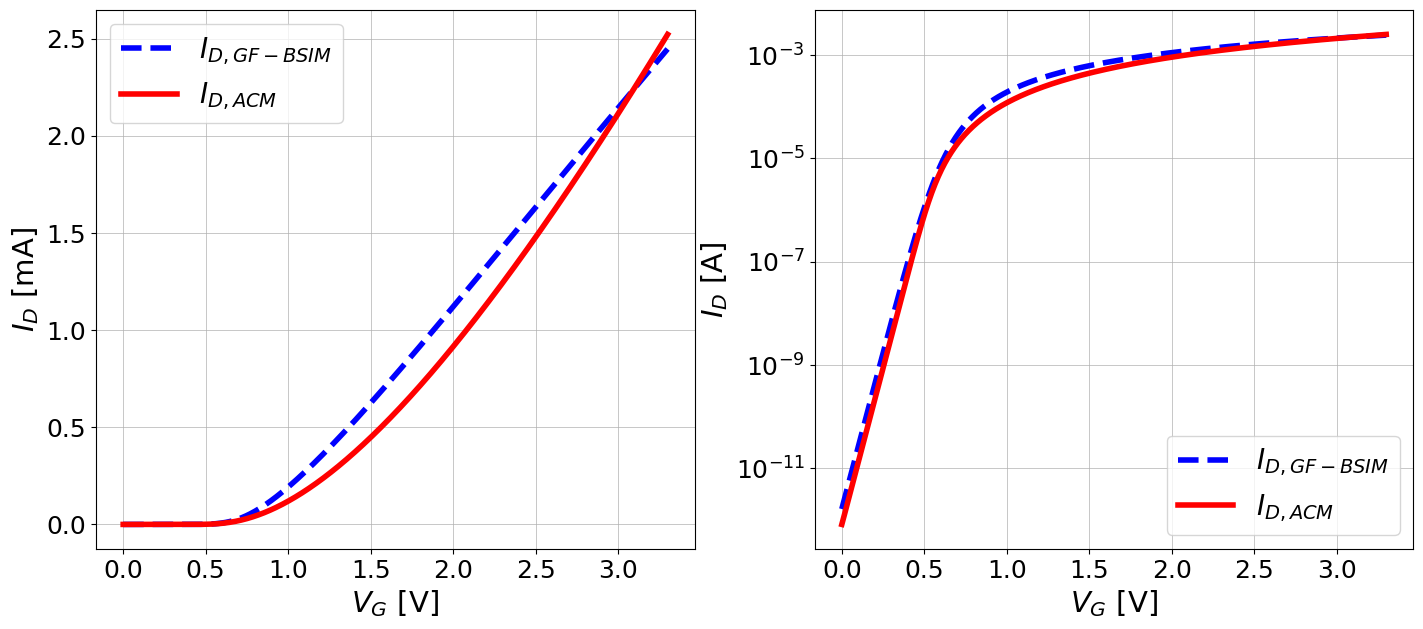

In [15]:
#@title Run ngspice and plot GF180mcu ACM2V0  vs. BSIM

!ngspice -b example1.spice ## Run ngspice

print()
print()
print()

data_ex1 = pd.read_csv("example1_out.txt", delim_whitespace=True, header=None)


data_ex1.columns = ["vg", "id_gf","null","id_acm"]
vg_nmos = data_ex1['vg']

#Creating figure
fig, ax1 = plt.subplots(1,2,figsize=(17, 7))
#ax2 = ax1.twinx()

ax1[0].plot(data_ex1['vg'],data_ex1['id_gf']*10**(3),'b--',linewidth=4,label='$I_{D,GF-BSIM}$')
ax1[0].plot(data_ex1['vg'],data_ex1['id_acm']*10**(3),'r',linewidth=4,label='$I_{D,ACM}$')

ax1[1].semilogy(data_ex1['vg'],data_ex1['id_gf'],'b--',linewidth=4,label='$I_{D,GF-BSIM}$')
ax1[1].semilogy(data_ex1['vg'],data_ex1['id_acm'],'r',linewidth=4,label='$I_{D,ACM}$')


#Labels
#ax1[0].set_title('NMOS-> $I_{D}$ vs. $V_{G}$')
ax1[0].title.set_fontsize(20)

ax1[0].set_xlabel('$V_{G}$ [V]',fontsize=21)
ax1[0].set_ylabel('$I_{D}$ [mA]',fontsize=21)

ax1[1].set_xlabel('$V_{G}$ [V]',fontsize=21)
ax1[1].set_ylabel('$I_{D}$ [A]',fontsize=21)



# X and Y axis tick font size
for label in (ax1[0].get_xticklabels() + ax1[0].get_yticklabels()):
	label.set_fontsize(18)

for label in (ax1[1].get_xticklabels() + ax1[1].get_yticklabels()):
	label.set_fontsize(18)

#grid
ax1[0].grid(linewidth=0.5)
ax1[0].legend(loc=2,fontsize=20)

ax1[1].grid(linewidth=0.5)
ax1[1].legend(loc=4,fontsize=20)
